# MazeDrone with TF Agents - 05 Train and Save Agent

This notebook aims to develop a script capable of saving the agent and its policy, loading it again and  continue training it. 

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

2024-12-09 17:25:05.065883: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 17:25:05.071508: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 17:25:05.174047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 17:25:06.582764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [2]:
num_iterations = 3_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

rewards = []
# rewards.append({
#     'destroyed': 0.,
#     'stuck': - 50.,
#     'reached': 100.,
#     'standard': -10.
# })
# rewards.append({
#     'destroyed': -60.,
#     'stuck': - 50.,
#     'reached': 100.,
#     'standard': -10.
# })
rewards.append({
    'destroyed': -10.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})
# rewards.append({
#     'destroyed': -150.,
#     'stuck': - 50.,
#     'reached': 100.,
#     'standard': -10.
# })

### Environment

In [3]:
sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

In [4]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 1.       ,  1.       ,  0.       ,  1.       ,  2.236068 ,
        1.1071488, -1.       , -1.       , -1.       , -1.       ,
       -1.       , -1.       , -1.       , -1.       , -1.       ,
       -1.       , -1.       , -1.       , -1.       , -1.       ,
       -1.       ], dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [5]:
train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

## Training Loop

In [6]:
description = "05"
maze_size = 3

In [7]:
from resources import build_agent, TrainingSession
import pandas as pd
import gc

In [8]:
# Agent fully connected layer params 
fc_layer_params = (200,) 

# print('Combination', combination + 1, ' | Run', run + 1)

# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env)
agent.initialize()

# GENERATE TRAINING SESSION
session = TrainingSession(description, maze_size, env_name, rewards[0], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, log_loss, replay_buffer, agent = session.train(without_wall_training=True, early_stop="crash")

# # LOGGING
# df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped})
# df_log.to_csv(f"logs/01-rewards-combinations/04_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)

# # CLEAR MEMORY
# del(agent)
# del(session)
# del(df_log)
# gc.collect()


Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Mode set: 1
Mode set: 1
Maze site set: 3x3
Maze site set: 3x3
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Rewards: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Early stop reseted at 100
Early stop reseted at 200
Early stop reseted at 300
Early stop reseted at 400
Early stop reseted at 500
Early stop reseted at 600
Early stop reseted at 700
Early stop reseted at 800
Early stop reseted at 900
step = 1000
Early stop reseted at 1000
Early stop reseted at 1100
Early stop reseted at 1200
Early stop reseted at 1300
Earl

## Visualization

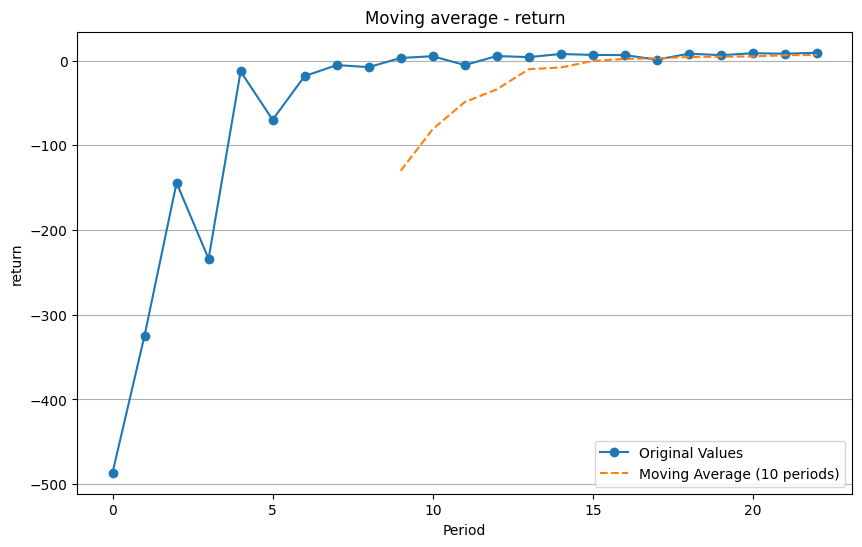

In [15]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

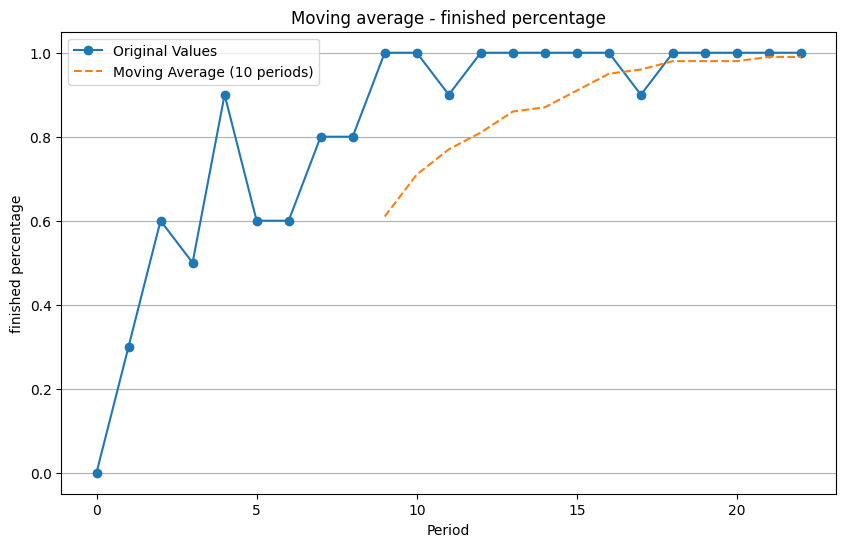

In [10]:
plot_moving_avg('finished percentage', finished)

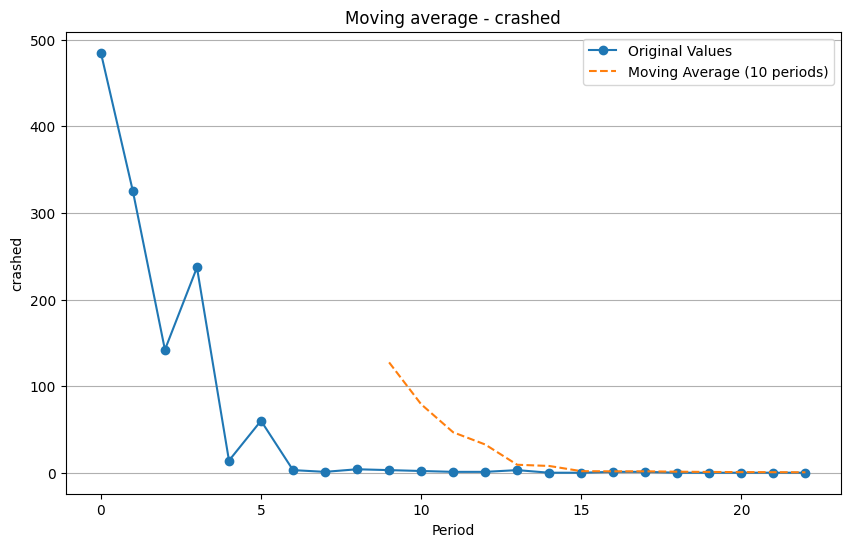

In [11]:
plot_moving_avg('crashed', crashed)

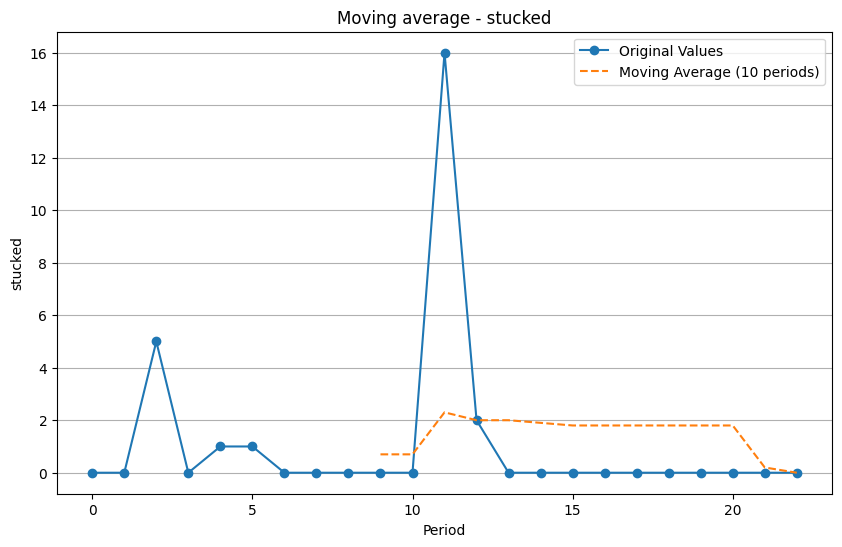

In [12]:
plot_moving_avg('stucked', stucked)

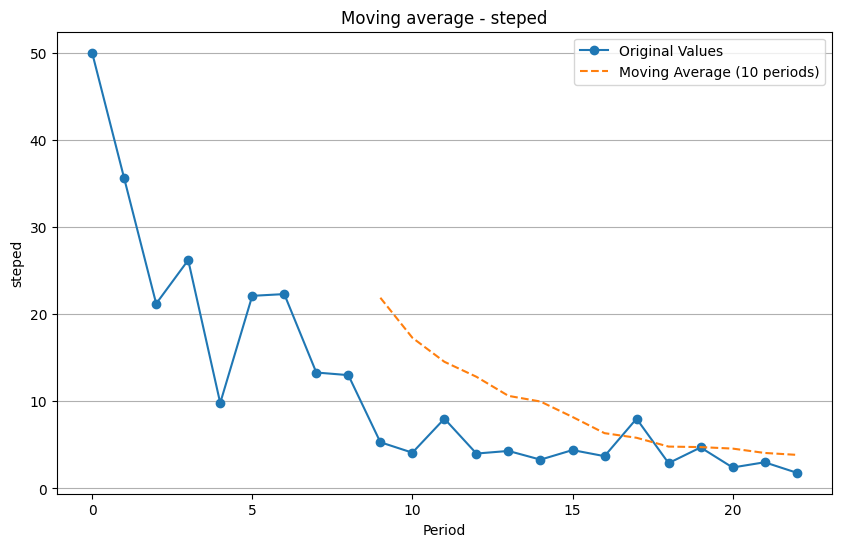

In [13]:
plot_moving_avg('steped', steped)

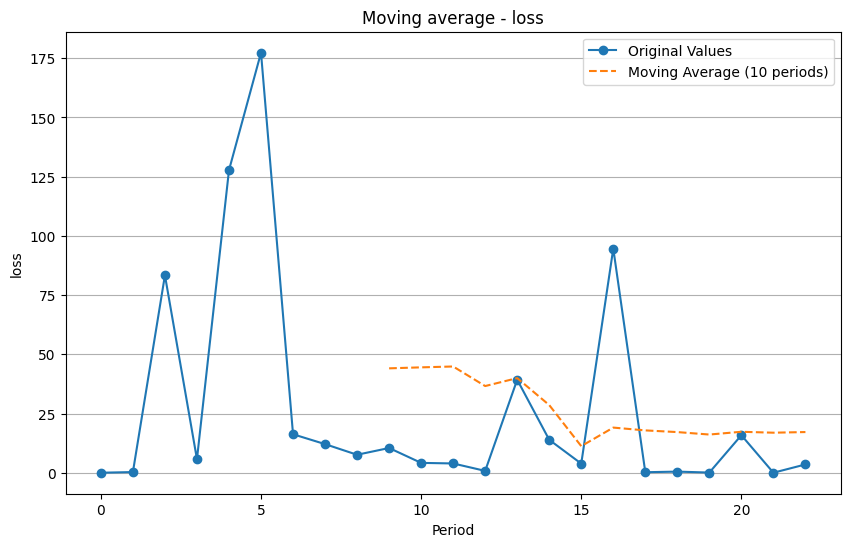

In [14]:
plot_moving_avg('loss', log_loss)

In [24]:
from resources import create_policy_eval_video


# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(0)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", train_env, train_py_env)

Mode set: 0


In [16]:
print('global_step:')
print(agent.train_step_counter)

global_step:
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2200>


In [17]:
checkpoint_dir = './checkpoint/phase-1-1-crash'

train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)


In [18]:
train_checkpointer.save(agent.train_step_counter)

In [19]:
import pandas as pd

In [21]:
df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})

In [22]:
df_log.to_csv(f"logs/04-stateChange/{description}_comb-2-run-checkpoint.csv", index=None, header=True)